# Bitcoin Daily: April 01, 2015 - May 31, 2020

In [4]:
import os
import time
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df2 = pd.read_csv("/content/Daily_BTCUSD_Yahoo_Finance_31052020.csv",
                  index_col=0)
df2 = df2.rename_axis("Timestamp")
print(df2.head())

                  Open        High  ...   Adj Close    Volume
Timestamp                           ...                      
2014-09-17  465.864014  468.174011  ...  457.334015  21056800
2014-09-18  456.859985  456.859985  ...  424.440002  34483200
2014-09-19  424.102997  427.834991  ...  394.795990  37919700
2014-09-20  394.673004  423.295990  ...  408.903992  36863600
2014-09-21  408.084991  412.425995  ...  398.821014  26580100

[5 rows x 6 columns]


In [0]:
NEXT = 1
df2 = df2.fillna(method='ffill')

df2['Future_Price'] = df2['Adj Close'].shift(-NEXT)
df2['Label'] = df2.apply(
    lambda x: (1) if x['Future_Price'] > x['Adj Close'] else (-1), axis=1)
#delete the last data as they do not have corresponding future prices
df2 = df2.iloc[:-NEXT, :] 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faac8fd0198>,
      dtype=object)

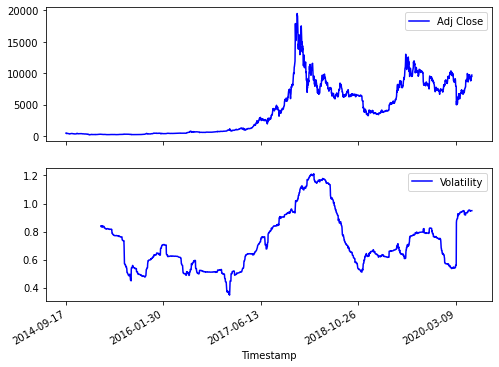

In [6]:
# Compute the logarithmic returns using the Closing price 
df2['Log_Ret'] = np.log(df2['Adj Close'] / df2['Adj Close'].shift(1))

# Compute Volatility using the pandas rolling standard deviation function
df2['Volatility'] = df2['Log_Ret'].rolling(window=180).std() * np.sqrt(365)

# Plot the NIFTY Price series and the Volatility
df2[['Adj Close', 'Volatility']].plot(subplots=True, color='blue',figsize=(8, 6))

In [7]:
df2.corr(method='pearson')

,Open,High,Low,Close,Adj Close,Volume,Future_Price,Label,Log_Ret,Volatility
Open,1.000000,0.998799,0.998016,0.997439,0.997439,0.670268,0.994758,-0.044718,-0.037167,0.621526
High,0.998799,1.000000,0.997566,0.998904,0.998904,0.670520,0.996310,-0.044621,-0.009760,0.625268
Low,0.998016,0.997566,1.000000,0.998651,0.998651,0.672524,0.995979,-0.046194,-0.003694,0.615391
Close,0.997439,0.998904,0.998651,1.000000,1.000000,0.671079,0.997438,-0.046365,0.017456,0.620880
Adj Close,0.997439,0.998904,0.998651,1.000000,1.000000,0.671079,0.997438,-0.046365,0.017456,0.620880
Volume,0.670268,0.670520,0.672524,0.671079,0.671079,1.000000,0.669923,-0.038544,0.004475,0.241979
Future_Price,0.994758,0.996310,0.995979,0.997438,0.997438,0.669923,1.000000,-0.014971,0.017629,0.620817
Label,-0.044718,-0.044621,-0.046194,-0.046365,-0.046365,-0.038544,-0.014971,1.000000,-0.047482,-0.031953
Log_Ret,-0.037167,-0.009760,-0.003694,0.017456,0.017456,0.004475,0.017629,-0.047482,1.000000,-0.018672
Volatility,0.621526,0.625268,0.615391,0.620880,0.620880,0.241979,0.620817,-0.031953,-0.018672,1.000000


# Features Selection

## Moving Average (14 & 30 days)=(2 weeks & 1 month)


In [0]:
# compute accuracy & smoothness
def MA_acc_smooth(price, MA, p):
  cost = pd.concat([price, MA], axis=1)
  cost.columns = ['Price', 'MA']
  cost['MA_Lag1'] = cost['MA'].shift(1)
  cost['MA_Lag2'] = cost['MA'].shift(2)
  cost = cost.iloc[p-1:,:] #no avialable MA in the first p days
  
  cost = cost.reset_index()
  
  # sum the absoluate values of differences
  cost['Acc'] = np.abs(cost['Price'] - cost['MA']).cumsum()
  cost['Smooth'] = cost.apply(
      lambda x: (0) if int(x.name) < 2 
      else np.abs(x['MA']-2*x['MA_Lag1']+x['MA_Lag2']),
      axis=1)
  cost['Smooth'] = cost['Smooth'].cumsum()

  # take the avg
  cost['Acc'] = cost.apply(lambda x: x['Acc']/(int(x.name)+1), axis=1)
  cost['Smooth'] = cost.apply(
      lambda x: (0) if int(x.name) < 2 else x['Smooth']/(int(x.name)-1),
      axis=1)
  
  cost = cost.iloc[2:, :] # the top two don't have smoothness
  cost = cost.set_index('Timestamp')
  return cost['Acc'], cost['Smooth']

### SMA

In [0]:
P1 = 14 #short period of 14 days (2 weeks)
P2 = 30 #long period of 30 days (1 month)

# assign simple moving average (SMA) with short & long periods
df2['SMA_14'] = df2['Adj Close'].rolling(window=P1).mean()
df2['SMA_30'] = df2['Adj Close'].rolling(window=P2).mean()

# compute accuracy & smoothness for both short and long periods
df2['Acc_14'], df2['Smooth_14'] = MA_acc_smooth(df2['Adj Close'], 
                                                df2['SMA_14'], 14)
df2['Acc_30'], df2['Smooth_30'] = MA_acc_smooth(df2['Adj Close'], 
                                                df2['SMA_30'], 30)

### CMA

Raudys, Aistis, and Židrina Pabarškaitė. "Optimising the Smoothness and Accuracy of Moving Average for Stock Price Data." Technological and Economic Development of Economy 24.3 (2018): 984-1003. Web.

In [0]:
DELTA =0.1 #0.0001 #1 #0.1 #0.001#
STEP =0.00000055 #0.00000070 #0.00000064  #0.000000666 #0.00000070 #

def delta_weights(price, MA, acc, smooth, p, DELTA=0.1, STEP=6.6e-7, W_0=0):
  cost = pd.concat([price, MA, acc, smooth], axis=1)
  cost.columns = ['Price', 'MA', 'Acc', 'Smooth']
  cost['MA_Lag1'] = cost['MA'].shift(1)
  cost['MA_Lag2'] = cost['MA'].shift(2)

  # assgin lag prices as vectors on everyday
  lag_prices = []
  cost['Price'].rolling(window=p).apply(
      lambda x: lag_prices.append(x.values) or 0, raw=False)
  cost.loc[p-1:, 'Lag_Prices'] = pd.Series(lag_prices).values

  # find the delta_C^n_i
  cost['Lag_1'] = cost['Lag_Prices'].shift(1)
  cost['Lag_2'] = cost['Lag_Prices'].shift(2)
  cost['Delta_Prices'] = cost['Lag_Prices']-2*cost['Lag_1']+cost['Lag_2']
  
  cost = cost.iloc[p-1:,:] # as top p days do not have MA
  
  # compute the sign of pair difference (SMA & price) & (smoothness & constant) 
  cost['Acc_Sign'] = cost.apply(
      lambda x: (x['Lag_Prices']) if x['MA'] > x['Price'] 
      else (-x['Lag_Prices']), axis = 1)
  cost['Smooth_Sign'] = cost.apply(
      lambda x: (DELTA) if x['Smooth'] > x['Acc'] else (-DELTA), axis = 1)
  cost['Delta_Sign'] = cost.apply(
      lambda x: (x['Delta_Prices']) if x['MA']-2*x['MA_Lag1']+x['MA_Lag2'] > 0 
      else (-x['Delta_Prices']), axis = 1)
  
  cost = cost.reset_index()
 
  cost['Delta_Acc'] = cost['Acc_Sign'].cumsum()
  cost['Delta_Smooth'] = cost['Delta_Sign']
  cost['Delta_Smooth'].iloc[:2] = 0 #top 2 don't have smoothness
  cost['Delta_Smooth'] = cost['Delta_Smooth'].cumsum()

  # take average
  cost['Delta_Acc'] = cost.apply(
      lambda x: x['Delta_Acc']/(int(x.name)+1), axis=1)
  cost['Delta_Smooth'] = cost.apply(
      lambda x: (0) if int(x.name) < 2
      else (x['Smooth_Sign']*x['Delta_Smooth']/(int(x.name)-1)), axis = 1)
  
  # compute the derivative of cost w.r.t. weight
  cost['Delta_Weight'] = cost['Delta_Acc'] + cost['Delta_Smooth'] 
  cost = cost.set_index('Timestamp')
  cost = cost.iloc[2:, :] #top 2 elements don't have smoothness

  # update weights by gradient optimisation
  cost['Weight'] = W_0 - (STEP)*(cost['Delta_Weight'].cumsum())

  # compute customize MA
  cost['CMA'] = cost['Weight']*cost['Lag_Prices']
  cost['CMA'] = cost.apply(lambda x: sum(x['CMA']), axis=1)

  plt.plot(cost['Weight'].iloc[-1], label='weights')
  plt.legend()
  plt.show() 
  return cost['CMA']

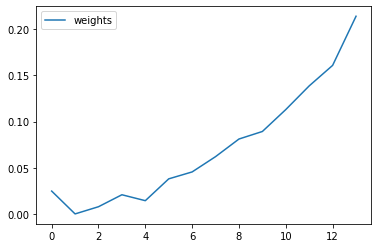

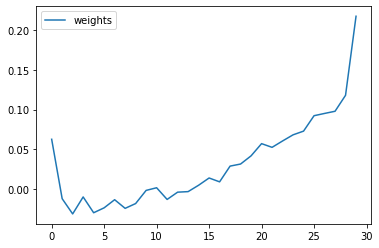

In [11]:
df2['CMA_14'] = delta_weights(df2['Adj Close'], df2['SMA_14'], df2['Acc_14'], 
                              df2['Smooth_14'], 14, STEP=4.6e-7, DELTA=1, W_0=0.02)
df2['CMA_30'] = delta_weights(df2['Adj Close'], df2['SMA_30'], df2['Acc_30'], 
                              df2['Smooth_30'], 30, STEP=2.5e-7, DELTA=5, W_0=0.01)

In [0]:
df2['MA_Avg'] = (df2['SMA_14'] + df2['CMA_14'] + df2['CMA_30'])/3
df2['MA_Sign'] = df2.apply(
    lambda x: (1) if x['Adj Close'] > x['MA_Avg'] else (-1), axis=1)

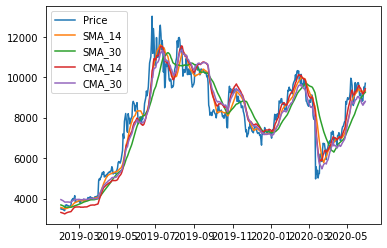

In [13]:
import datetime as dt
TIME = '2019-02-01'
df3 = df2[TIME:]
#df3, df3_minmax = minmax_normalization(df3)
df3 = df3.set_index(pd.to_datetime(df3.index))
plt.plot(df3['Adj Close'], label='Price')
plt.plot(df3['SMA_14'], label='SMA_14')
plt.plot(df3['SMA_30'], label='SMA_30')
plt.plot(df3['CMA_14'], label='CMA_14')
plt.plot(df3['CMA_30'], label='CMA_30')
plt.legend()
plt.show()

*   As DELTA goes up, the smoothness goes down, the CMA becomes more fluctuated. (better)
*   As STEP goed up, the learning rate goes up and the makes CMA more approachable to actual price than SMA, which makes better.


However, we cannot raise both parameters since they both increase the CMA dramatically. We have to find the trade off between them.

*   For long and short period, easy to see, it improves a lot in long MA. But the long CMA also show some delay. 
*   Although we want to increse the DELTA to reduce smoothness, but we can't do in the short period. As it leads the limited lag parameters(only 14) behaves too flucauated and weird. But it's proper to try in long periods since the number of lag parameters are large. It won't effect dramatically when the weights for the oldest prices are fluactuated/weird. 


In [0]:
# MA evaluation: MA < price, advise an up trend; otherwise, down trend
def MA_evaluation(price, MA, label, MA_type):
  MA_data = pd.concat([price, MA, label], axis=1)
  MA_data.columns = ['Price', 'MA', 'Label']

  # MA < price, advise an up trend; otherwise, down trend
  MA_data['MA_Label'] = MA_data.apply(lambda x: (1) if x['Price'] > x['MA'] 
                                      else (-1), axis=1)
  MA_data['MA_Acc'] = MA_data.apply(lambda x: (1) if x['Label'] == x['MA_Label'] 
                                      else (0), axis=1)
  MA_acc = (MA_data['MA_Acc'].sum())/MA_data.shape[0]
  print(MA_type, 'Sign Accuracy: {:.2f}%'.format(MA_acc*100))

In [15]:
MA_evaluation(df3['Adj Close'], df3['SMA_14'], df3['Label'], 'SMA_14')
MA_evaluation(df3['Adj Close'], df3['CMA_14'], df3['Label'], 'CMA_14')
MA_evaluation(df3['Adj Close'], df3['SMA_30'], df3['Label'], 'SMA_30')
MA_evaluation(df3['Adj Close'], df3['CMA_30'], df3['Label'], 'CMA_30')
MA_evaluation(df3['Adj Close'], df3['MA_Avg'], df3['Label'], 'MA_Avg')

SMA_14 Sign Accuracy: 52.99%
CMA_14 Sign Accuracy: 55.46%
SMA_30 Sign Accuracy: 53.20%
CMA_30 Sign Accuracy: 54.02%
MA_Avg Sign Accuracy: 54.64%


In [0]:
X = pd.concat([df2['Open'], df2['High'], df2['Low'],
               df2['Close'], df2['Volume'], df2['Volatility']], axis = 1)

# add SMA_14, CMA_14 and CMA_30 as features
# X = pd.concat([X, df2['SMA_14'], df2['CMA_14'], df2['SMA_30'], df2['CMA_30'], df2['MA_Avg']], axis = 1)

X = pd.concat([X, df2['MA_Avg']], axis = 1)

## Lag

In [0]:
from sklearn import preprocessing

LAG = 10

lags = pd.concat([df2['Adj Close'].shift(i) for i in range (LAG+1)], axis = 1)
lags.columns = [str(i) for i in range(LAG+1)]

X = pd.concat([lags, X], axis=1)
X = X.iloc[LAG:,:]

y_reg = pd.DataFrame(df2['Future_Price'].iloc[LAG:])
data = pd.concat([y_reg, X], axis = 1)
data = data.set_index(pd.to_datetime(data.index))

## Cryptocurrencies

In [0]:
# explore other top 9 cryptocurrencies inputs 
ETH = pd.read_csv("/content/ETH-USD_Yahoo_31052020.csv", 
                  index_col=0).rename_axis("Timestamp")
XRP = pd.read_csv("/content/XRP-USD_Yahoo_31052020.csv",
                  index_col=0).rename_axis("Timestamp")
USDT = pd.read_csv("/content/USDT-USD_Yahoo_31052020.csv",
                   index_col=0).rename_axis("Timestamp")
BCH = pd.read_csv("/content/BCH-USD_Yahoo_31052020.csv",
                  index_col=0).rename_axis("Timestamp")
BSV = pd.read_csv("/content/BSV-USD_Investing_31052020.csv",
                  index_col=0).rename_axis("Timestamp")[::-1]
LTC = pd.read_csv("/content/LTC-USD_Yahoo_31052020.csv",
                  index_col=0).rename_axis("Timestamp")
EOS = pd.read_csv("/content/EOS-USD_Yahoo_31052020.csv",
                  index_col=0).rename_axis("Timestamp")
BNB = pd.read_csv("/content/BNB-USD_Yahoo_31052020.csv",
                  index_col=0).rename_axis("Timestamp")
XTZ = pd.read_csv("/content/XTZ-USD_Investing_31052020.csv",
                  index_col=0).rename_axis("Timestamp")[::-1]

In [0]:
ETH = ETH.set_index(pd.to_datetime(ETH.index))
XRP = XRP.set_index(pd.to_datetime(XRP.index))
USDT = USDT.set_index(pd.to_datetime(USDT.index))
BCH = BCH.set_index(pd.to_datetime(BCH.index))
BSV = BSV.set_index(pd.to_datetime(BSV.index))
LTC = LTC.set_index(pd.to_datetime(LTC.index))
EOS = EOS.set_index(pd.to_datetime(EOS.index))
BNB = BNB.set_index(pd.to_datetime(BNB.index))
XTZ = XTZ.set_index(pd.to_datetime(XTZ.index))

In [100]:
crypto = pd.concat([ETH['Adj Close'], XRP['Adj Close'], USDT['Adj Close'],
                    BCH['Adj Close'], BSV['Price'], LTC['Adj Close'],
                    EOS['Adj Close'], BNB['Adj Close'], XTZ['Price']], 
                   axis = 1)
crypto.columns = ['ETH', 'XRP', 'USDT', 'BCH', 'BSV', 'LTC', 
                  'EOS', 'BNB', 'XTZ']
#crypto = crypto.fillna(method='ffill')
crypto = crypto.iloc[:, :2]
data_crypto = pd.concat([data, crypto.iloc[:-1, :]], axis = 1)
data = data_crypto
data_crypto.corr(method='pearson')

,Future_Price,0,Open,High,Low,Close,Volume,Volatility,ETH,XRP
Future_Price,1.000000,0.997438,0.994758,0.996310,0.995979,0.997438,0.669923,0.620817,0.737707,0.725738
0,0.997438,1.000000,0.997439,0.998904,0.998651,1.000000,0.671079,0.620880,0.742850,0.730195
Open,0.994758,0.997439,1.000000,0.998799,0.998016,0.997439,0.670268,0.621526,0.744493,0.731953
High,0.996310,0.998904,0.998799,1.000000,0.997566,0.998904,0.670520,0.625268,0.748319,0.734417
Low,0.995979,0.998651,0.998016,0.997566,1.000000,0.998651,0.672524,0.615391,0.736090,0.725010
Close,0.997438,1.000000,0.997439,0.998904,0.998651,1.000000,0.671079,0.620880,0.742850,0.730195
Volume,0.669923,0.671079,0.670268,0.670520,0.672524,0.671079,1.000000,0.241979,0.195101,0.275493
Volatility,0.620817,0.620880,0.621526,0.625268,0.615391,0.620880,0.241979,1.000000,0.836617,0.631628
ETH,0.737707,0.742850,0.744493,0.748319,0.736090,0.742850,0.195101,0.836617,1.000000,0.874551
XRP,0.725738,0.730195,0.731953,0.734417,0.725010,0.730195,0.275493,0.631628,0.874551,1.000000


## Exo factors

In [0]:
# explore exo inputs stocke markets: FTSE100 & DJI, commodities: gold & oil, 
# exchange rates: EUR/USD, USD/CNY
FTSE = pd.read_csv("/content/FTSE_Investing_31052020.csv", 
                  index_col=0).rename_axis("Timestamp")[::-1]
DJI = pd.read_csv("/content/DJI_Yahoo_Finance_31052020.csv",
                  index_col=0).rename_axis("Timestamp")
gold = pd.read_csv("/content/GOLD_Yahoo_31052020.csv",
                  index_col=0).rename_axis("Timestamp")
oil = pd.read_csv("/content/Oil_Yahoo_31052020.csv",
                  index_col=0).rename_axis("Timestamp")
EURUSD = pd.read_csv("/content/EURUSD_Yahoo_31052020.csv",
                     index_col=0).rename_axis("Timestamp")
USDCNY = pd.read_csv("/content/USDCNY_Yahoo_31052020.csv",
                  index_col=0).rename_axis("Timestamp")

In [0]:
FTSE = FTSE.set_index(pd.to_datetime(FTSE.index))
DJI = DJI.set_index(pd.to_datetime(DJI.index))
gold = gold.set_index(pd.to_datetime(gold.index))
oil = oil.set_index(pd.to_datetime(oil.index))
EURUSD = EURUSD.set_index(pd.to_datetime(EURUSD.index))
USDCNY = USDCNY.set_index(pd.to_datetime(USDCNY.index))
FTSE['Price'] = FTSE['Price'].str.replace(',', '').astype(float)

In [134]:
exo = pd.concat([FTSE['Price'], DJI['Adj Close'], gold['Adj Close'], 
                 oil['Adj Close'], EURUSD['Adj Close'], USDCNY['Adj Close']], 
                axis = 1)
exo.columns = ['FTSE', 'DJI', 'Gold', 'Oil', 'EURUSD', 'USDCNY']
#exo = exo.fillna(method='ffill')
data_exo = pd.concat([data, exo], axis = 1)
data = data_exo
data_exo.corr(method='pearson')

,Future_Price,0,Open,High,Low,Close,Volume,Volatility,FTSE,NASDAQ,Gold,Oil,EURUSD,USDCNY
Future_Price,1.000000,0.997438,0.994758,0.996310,0.995979,0.997438,0.669923,0.620817,0.505811,0.846070,0.551009,0.226132,0.245328,0.440423
0,0.997438,1.000000,0.997439,0.998904,0.998651,1.000000,0.671079,0.620880,0.506742,0.846194,0.550371,0.228690,0.245461,0.440759
Open,0.994758,0.997439,1.000000,0.998799,0.998016,0.997439,0.670268,0.621526,0.507887,0.845995,0.548600,0.231360,0.247419,0.439223
High,0.996310,0.998904,0.998799,1.000000,0.997566,0.998904,0.670520,0.625268,0.505016,0.839068,0.542636,0.228025,0.250812,0.433476
Low,0.995979,0.998651,0.998016,0.997566,1.000000,0.998651,0.672524,0.615391,0.509703,0.856387,0.559633,0.231111,0.239762,0.450049
Close,0.997438,1.000000,0.997439,0.998904,0.998651,1.000000,0.671079,0.620880,0.506742,0.846194,0.550371,0.228690,0.245461,0.440759
Volume,0.669923,0.671079,0.670268,0.670520,0.672524,0.671079,1.000000,0.241979,0.029440,0.756585,0.795883,-0.201244,-0.132194,0.554551
Volatility,0.620817,0.620880,0.621526,0.625268,0.615391,0.620880,0.241979,1.000000,0.307238,0.392530,0.128894,0.249288,0.670452,-0.215759
FTSE,0.505811,0.506742,0.507887,0.505016,0.509703,0.506742,0.029440,0.307238,1.000000,0.516402,0.135482,0.588875,0.185381,0.240365
NASDAQ,0.846070,0.846194,0.845995,0.839068,0.856387,0.846194,0.756585,0.392530,0.516402,1.000000,0.730961,0.184014,0.012568,0.663016


## Customize features 

In [0]:
CF = pd.concat([ETH['Adj Close'], USDT['Adj Close'], EURUSD['Adj Close']],
               axis=1)
CF.columns = ['ETH', 'USDT', 'EURUSD']
data_CF = pd.concat([data, CF.iloc[:-1, :]], axis = 1)

del data_CF['Volatility'], data_CF['1'], data_CF['2'], data_CF['3'],
del data_CF['6'], data_CF['7'], data_CF['8']
data = data_CF

In [193]:
data.tail()

,Future_Price,0,4,5,9,10,Open,High,Low,Close,Volume,MA_Avg,ETH,USDT,EURUSD
Timestamp,,,,,,,,,,,,,,,
2020-05-26,9181.017578,8835.052734,9182.577148,9081.761719,9670.739258,9377.013672,8909.585938,8991.967773,8757.293945,8835.052734,2.958419e+10,9033.840902,201.902313,0.998008,1.090300
2020-05-27,9525.750977,9181.017578,9209.287109,9182.577148,9726.575195,9670.739258,8837.380859,9203.320313,8834.157227,9181.017578,3.274054e+10,9045.845155,208.863434,1.004554,1.098177
2020-05-28,9439.124023,9525.750977,8790.368164,9209.287109,9729.038086,9726.575195,9184.945313,9546.319336,9148.457031,9525.750977,3.436707e+10,9106.533161,219.840439,1.001153,1.101686
2020-05-29,9700.414063,9439.124023,8906.934570,8790.368164,9522.981445,9729.038086,9528.355469,9573.666992,9379.338867,9439.124023,3.289664e+10,9117.033447,220.675125,1.003355,1.107911
2020-05-30,9461.058594,9700.414063,8835.052734,8906.934570,9081.761719,9522.981445,9438.914063,9704.030273,9366.729492,9700.414063,3.272298e+10,9184.183538,242.345596,1.000403,NaN


## Split data

In [0]:
from sklearn.preprocessing import MinMaxScaler

# minmax normalization of dataframe
def minmax_normalization(data):
  val = data.values #returns a numpy array
  min_max_scaler = MinMaxScaler()
  val_scaled = min_max_scaler.fit_transform(val)

  # cover to dataframe with same features
  data_scaled = pd.DataFrame(val_scaled)
  data_scaled.columns = [col for col in data.columns]
  data = data_scaled.set_index(data.index) 
  return data, min_max_scaler

def undo_minmax_normalization(pred, X, scaler):
  data = pd.concat([pred, X], axis=1)
  val = data.values #returns a numpy array
  data_undo = pd.DataFrame(scaler.inverse_transform(data))
  data_undo.columns = [col for col in data.columns]
  data = data_undo.set_index(data.index) 
  return data

# convert minmax normalized prediction into price
def convert_to_price(pred, X):
  #pred_price = pd.concat([pred, X], axis=1)
  pred_price = undo_minmax_normalization(pred, X, data_minmax).iloc[:,0]
  pred_price = pd.DataFrame(pred_price)
  pred_price.columns = ['Pred_Price']
  return pred_price

In [0]:
import datetime as dt
from sklearn import preprocessing

TIME = dt.datetime(2020,2,1) # 00:00:00 1st Sep, 2019
#TIME = dt.datetime(2020,4,15) # 00:00:00 15th Apr, 2020
START = '2015-04-01'
#TIME = '2020-02-01'

#data = (data - data.mean())/data.std() #standardize

data_scaled, data_minmax = minmax_normalization(data)
data_scaled = data_scaled.fillna(0.0)

train = data_scaled[START:TIME].iloc[:-1, :]
test = data_scaled[TIME:]

X_train, y_train_reg = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test_reg = test.iloc[:, 1:], test.iloc[:, 0]

# Benchmarks

In [0]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def penalty_error(price, future_price, pred, label, pred_label):
  penalty_data = pd.concat([price, future_price, pred, label, pred_label], 
                           axis=1)
  penalty_data.columns = ['Price','Future_Price', 'Pred', 'Label', 'Pred_Label']

  # give the penalty as 2 times when the predicted sign is wrong
  penalty_data['Label_Penalty'] = penalty_data.apply(
      lambda x: (1) if x['Label'] == x['Pred_Label'] else (2), axis=1)
  penalty_data['Error'] = np.abs(penalty_data['Future_Price'] - penalty_data['Pred'])
  penalty_data['Error'] /= penalty_data['Price']
  penalty_data['Error'] *= penalty_data['Label_Penalty'] 
  error = (penalty_data['Error'].sum())/penalty_data.shape[0]
  return error


def performance(y, pred, X):
  mae = mean_absolute_error(y, pred)
  y_true, y_pred = np.array(y), np.array(pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  score = mean_squared_error(y, pred)
  rmse = np.sqrt(score)
  r2 = r2_score(y, pred)
  print("\n MAE: {:.4f}, MAPE: {:.2f}%".format(mae, mape))
  print("\n MSE: {:.4f}, RMSE: {:.4f}".format(score, rmse))

  # sign accuracy: +1 if price goes up, otherwise -1
  pred_summary = pd.concat([y, pred, X['0']], axis=1)
  pred_summary.columns = ['Future_Price', 'Pred', 'Price']
  pred_summary['Sign'] = pred_summary.apply(
      lambda x: (1) if x['Future_Price'] > x['Price'] else (-1), axis=1)
  pred_summary['Pred_Sign'] = pred_summary.apply(
      lambda x: (1) if x['Pred'] > x['Price'] else (-1), axis=1)
  pred_summary['Accuracy'] = pred_summary.apply(
      lambda x: (1) if x['Sign'] == x['Pred_Sign'] else (0), axis=1)
  accu = pred_summary['Accuracy'].sum()/pred_summary.shape[0]
  print("\n R^2: {:.4f}, Sign Accuracy: {:.2f}%".format(r2, accu*100))

  # compute mean error with penalty
  penalty_err = penalty_error(pred_summary['Price'], pred_summary['Future_Price'], 
                              pred_summary['Pred'], pred_summary['Sign'], 
                              pred_summary['Pred_Sign'])
  print('\n Mean Error with penalty: {:.4f}'.format(penalty_err))
  

  # convert the prediction to actual price
  y_price = convert_to_price(y, X)
  pred_price = convert_to_price(pred, X)
  plt.plot(y_price, label='price')
  plt.plot(pred_price, label='pred')
  plt.legend()
  plt.show()

## Naive


 MAE: 0.0124, MAPE: 21.93%

 MSE: 0.0004, RMSE: 0.0207

 R^2: 0.9240, Sign Accuracy: 48.33%

 Mean Error with penalty: 0.0479


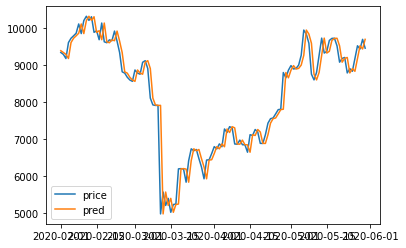

In [198]:
 pred_naive = pd.DataFrame(X_test['0'])
 pred_naive = pred_naive.set_index(y_test_reg.index)
 pred_naive.columns = ['Pred']
 performance(y_test_reg, pred_naive, X_test)

## ARMA

In [30]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 4.5MB/s 
     |████████████████████████████████| 2.1MB 21.1MB/s 
     |████████████████████████████████| 8.7MB 41.3MB/s 
  Found existing installation: Cython 0.29.19
    Uninstalling Cython-0.29.19:
      Successfully uninstalled Cython-0.29.19
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [0]:
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import scipy as sp

# Importing the Time Series Analysis module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults
import statsmodels.tsa.stattools as sm_tools

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm 
from datetime import datetime

In [0]:
def plot_check_residuals(model, title1='Figure', title2='Figure', ARMA=False):
    model_fitted_y = model.fittedvalues
    plt.figure(1, figsize=(15,12))
    plt.subplot(2,2, 1)
    plt.grid()
    plt_result = sns.regplot(model_fitted_y, model.resid, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 3, 'alpha': 0.8})
    plt_result.set_title(title1 + ' Residuals vs Fitted')
    plt_result.set_xlabel('Fitted values')
    plt_result.set_ylabel('Residuals')

    if (not ARMA):
        plt.subplot(2,2, 2) # 2 by 2 and plot 2
        plt.figure(1, figsize=(15,12))
        sqrt_stdRes = np.sqrt(np.abs(model.resid_pearson))
        plt.grid()
        plt_result = sns.regplot(model_fitted_y, sqrt_stdRes, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 3, 'alpha': 0.8})
        plt_result.set_title(title2 + ' Scale-Location')
        plt_result.set_xlabel('Fitted values')
        plt_result.set_ylabel('Sqrt Std Residuals')

    plt.show()

In [0]:
# Check diagonostics
def plot_diagnostics(data, title1 = 'Residuals', title2 = 'Figure '):
    
    m = np.log(len(data))
    ljbtest = sm.stats.acorr_ljungbox(data,int(m))
    fig, axs = plt.subplots(3,2, figsize=(12,12), constrained_layout=True)
    fig.suptitle(title2 + 'Diagnostics of ' + title1, fontsize=14)
    
    # Normal Histrogram and Plot of data
    axs[0,0].hist(data, bins =40,color='m', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    axs[0,0].plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    axs[0,0].set_title('Normal Histrogram')
    axs[0,1].plot(data)
    axs[0,1].set_title('Plot of ' + title1)
    
    # ACF and PACF of data
    axs[1,0].set_ylabel('ACF', fontsize=10)
    axs[1,0].set_xlabel('Lag', fontsize=10)
    fig = plot_acf(data,lags=40,zero=False, ax = axs[1,0], title= 'ACF '+ title1, use_vlines = True)
    axs[1,1].set_ylabel('PACF', fontsize=10)
    axs[1,1].set_xlabel('Lag', fontsize=10)
    fig = plot_pacf(data,lags=40,zero=False, ax = axs[1,1], title= 'PACF '+ title1, use_vlines = True)
    
    # Ljung-Box test and Normal QQ plot of data
    axs[2,0].plot(ljbtest[1])
    axs[2,0].axhline(y=0.05, color='r',ls='--')
    axs[2,0].set_title('Ljung-Box Test')
    fig = sm.qqplot(data, line='q',ax = axs[2,1])
    axs[2,1].set_title('Normal QQ Plot')
    
    # test results of normality Shapiro Wilk test and Jarque-Bera test
    SWtest = stats.shapiro(data)
    print('Shapiro Wilk Test Statistic: %f' % SWtest[0])
    print('p-value: %f' % SWtest[1])
    JBtest = stats.jarque_bera(data)
    print('Jarque-Bera Test Statistic: %f' % JBtest[0])
    print('p-value: %f' % JBtest[1])

In [0]:
#Improve simple code below to improve display
def plot_ACF_PACF(data, title1 = 'Figure '):

    fig, axes = plt.subplots(1,2,figsize=(15,5), constrained_layout=True)
    fig.suptitle(title1, fontsize=14)
    
    axes[0].set_ylabel('ACF', fontsize=10)
    axes[0].set_xlabel('Lag', fontsize=10)
    fig = plot_acf(data,lags=40,zero=False, ax = axes[0], title= 'ACF', use_vlines = True)
    axes[1].set_ylabel('PACF', fontsize=10)
    axes[1].set_xlabel('Lag', fontsize=10)
    fig = plot_pacf(data,lags=40,zero=False, ax = axes[1], title= 'PACF', use_vlines = True)
    
    #plt.savefig("ACF2.png", dpi = 300)

In [0]:
def check_normality(data):
    # Normality Shapiro Wilk test
    test = stats.shapiro(data)
    print('Shapiro Wilk Test Statistic: %f' % test[0])
    print('p-value: %f' % test[1])

    # Normality Jarque-Bera test
    test = stats.jarque_bera(data)
    print('Jarque-Bera Test Statistic: %f' % test[0])
    print('p-value: %f' % test[1])

def check_stationality(data):
    # unit root ADF test
    test = adfuller(data, maxlag = 5)
    print('ADF Statistic: %f' % test[0])
    print('p-value: %f' % test[1])

    # Stationarity Kpss test
    num = len(data)
    maxLag = np.log(num)
    test = kpss(data, lags = int(maxLag)) 
    print('KPSS Statistic: %f' % test[0])
    print('p-value: %f' % test[1])

In [291]:
check_stationality(df2['Adj Close']) # not stationary

ADF Statistic: -1.567141
p-value: 0.500075
KPSS Statistic: 17.757668
p-value: 0.010000


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [293]:
# use log return
log_ret = pd.DataFrame(df2['Log_Ret'].dropna())
check_stationality(log_ret)

ADF Statistic: -46.301250
p-value: 0.000000
KPSS Statistic: 0.157908
p-value: 0.100000


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


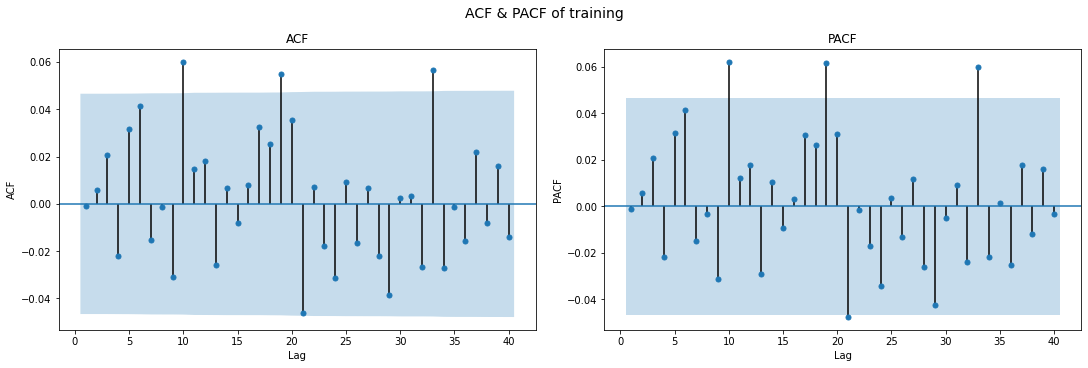

In [295]:
# assign train and test dataset
log_ret = log_ret.set_index(pd.to_datetime(log_ret.index))
X_train_log_ret = log_ret[START:TIME]
X_test_log_ret = log_ret[TIME:]

plot_ACF_PACF(X_train_log_ret, 'ACF & PACF of training')

In [0]:
# Define a very simple function to search for ARMA models based on min AIC

def searchARMA(data, max_p, max_q):
  aic = np.zeros((max_p,max_q))
  for i in range(max_p):
    print(i)
    for j in range(max_q):
      try:
        model = ARIMA(data, order=(i,0,j)).fit()
        aic[i,j] = model.aic
      except:
        continue
  
  min_aic = np.amin(aic)
  min_order = np.where(aic == min_aic)
  print('Minimum AIC:', min_aic)
  print('Order (p, q):', '(', int(min_order[0]),',', int(min_order[1]),')')

In [297]:
import warnings
warnings.filterwarnings('ignore')

searchARMA(X_train_log_ret, 6, 6)

0
1
2
3
4
5
Minimum AIC: -6564.841144113255
Order (p, q): ( 3 , 2 )


In [298]:
arma = ARIMA(X_train_log_ret, order = (3,0,2)).fit()
print(arma.summary())

                              ARMA Model Results                              
Dep. Variable:                Log_Ret   No. Observations:                 1768
Model:                     ARMA(3, 2)   Log Likelihood                3289.421
Method:                       css-mle   S.D. of innovations              0.038
Date:                Sun, 14 Jun 2020   AIC                          -6564.841
Time:                        17:42:09   BIC                          -6526.498
Sample:                    04-01-2015   HQIC                         -6550.674
                         - 02-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.001      2.290      0.022       0.000       0.004
ar.L1.Log_Ret    -1.1714      0.024    -49.087      0.000      -1.218      -1.125
ar.L2.Log_Ret    -0.9803      0.028    -

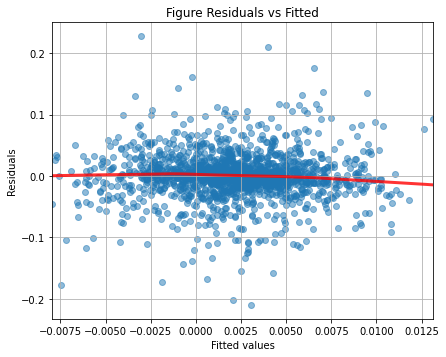

Shapiro Wilk Test Statistic: 0.916287
p-value: 0.000000
Jarque-Bera Test Statistic: 1826.624721
p-value: 0.000000


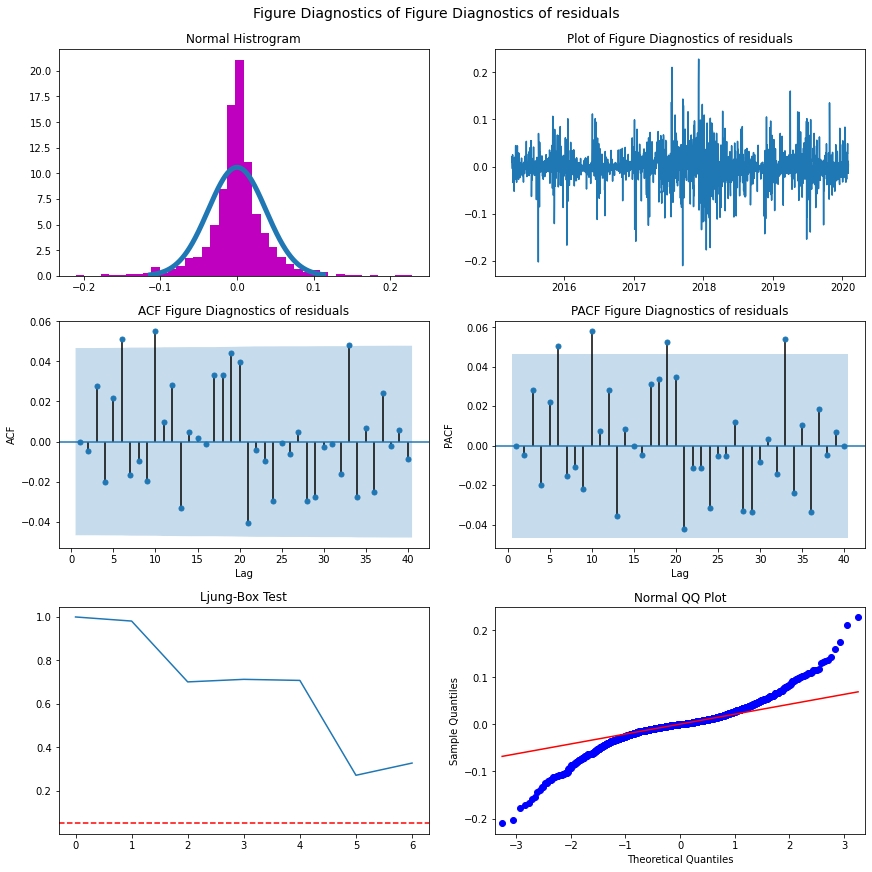

In [299]:
plot_check_residuals(arma, title1='Figure', title2='Figure', ARMA=True)
plot_diagnostics(arma.resid, 'Figure Diagnostics of residuals')

In [0]:
# calculate the prediction price by ARMA model
pred_arma = pd.DataFrame(arma.predict(start=TIME, end='2020-05-31'))

# convert log return to price 
pred_arma_today = np.exp(pred_arma.cumsum())*(X['0'].loc['2020-01-31'])
pred_arma_price = pred_arma_today.shift(-1).dropna() #forecast nextday price
pred_arma_price = pred_arma_price.set_index(y_test_reg.index)
pred_arma_price.columns = ['Pred_price']

In [301]:
pred_arma = list()
history = [x for x in X_train_log_ret.values]
for t in range(len(X_test_log_ret)):
  model = ARIMA(history, order=(3,0,2))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  pred_arma.append(yhat)
  obs = X_test_log_ret.values[t]
  history.append(obs)
  if t % 10 == 0:
    print(t)
  #print('predicted=%f, expected=%f' % (yhat, obs))

0
10
20
30
40
50
60
70
80
90
100
110



 MAE: 0.1152, MAPE: 31.79%

 MSE: 0.0183, RMSE: 0.1354

 R^2: -2.2621, Sign Accuracy: 50.00%

 Mean Error with penalty: 0.4698


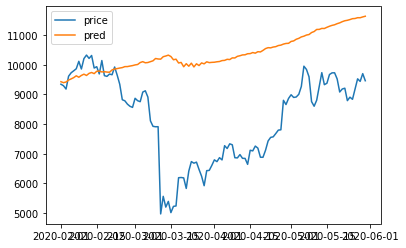

In [302]:
# convert log return to price 
pred_arma = pd.DataFrame(pred_arma)
pred_arma_price = np.exp(pred_arma.cumsum())*(X['0'].loc['2020-01-31'])
pred_arma_price = pred_arma_price.set_index(y_test_reg.index)
pred_arma_price.columns = ['Pred_price']

X_test_price = data[TIME:].iloc[:, 1:]
pred_arma = pd.concat([pred_arma_price, X_test_price], axis=1)

# MinMax normalization of prediction by ARMA
pred_arma = pd.DataFrame(data_minmax.transform(pred_arma)[:,0])
pred_arma.columns = ['Pred']
pred_arma = pred_arma.set_index(y_test_reg.index)
performance(y_test_reg, pred_arma, X_test) #performance in MinMax normalization

# Regression

In [0]:
import math 

def forecast(model, X, y, X_original):
  pred = pd.DataFrame(model.predict(X))
  pred = pred.set_index(y.index)
  pred.columns = ['Pred']
  
  performance(y, pred, X_original)
  return pred

## Linear


 MAE: 0.0120, MAPE: 21.91%

 MSE: 0.0004, RMSE: 0.0205

 R^2: 0.9252, Sign Accuracy: 59.17%

 Mean Error with penalty: 0.0479


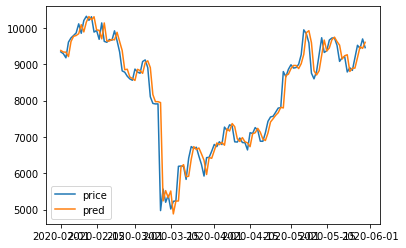

In [199]:
from sklearn.linear_model import RidgeCV

rr = RidgeCV()
rr.fit(X_train, y_train_reg)

pred_rr = forecast(rr, X_test, y_test_reg, X_test)

Feature ranking:
1. feature 8 (0.393662)
2. feature 0 (0.393662)
3. feature 6 (0.135611)
4. feature 7 (0.112827)
5. feature 3 (0.098640)
6. feature 4 (-0.084853)
7. feature 1 (0.069486)
8. feature 5 (-0.046536)
9. feature 2 (-0.045657)
10. feature 10 (-0.016869)
11. feature 11 (-0.010501)
12. feature 12 (-0.007374)
13. feature 13 (0.003436)
14. feature 9 (0.000365)


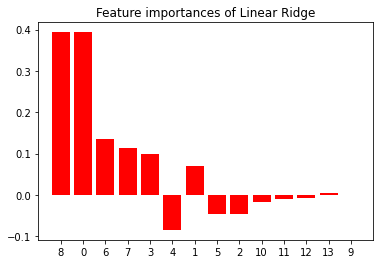

In [200]:
# only works for rr
def feature_importance_rr(model, X):
  importances = model.coef_
  indices = np.argsort(np.abs(importances))[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

  # Plot the feature importances of the linear model
  plt.figure()
  plt.title("Feature importances of Linear Ridge")
  plt.bar(range(X.shape[1]), importances[indices], color="r")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

feature_importance_rr(rr, X_test)

only the coefficient of Lag 1 is more than 0.05, but the contribution is little. Better to use without lag. 

## Random forest


 MAE: 0.0144, MAPE: 21.84%

 MSE: 0.0005, RMSE: 0.0221

 R^2: 0.9128, Sign Accuracy: 48.33%

 Mean Error with penalty: 0.0585


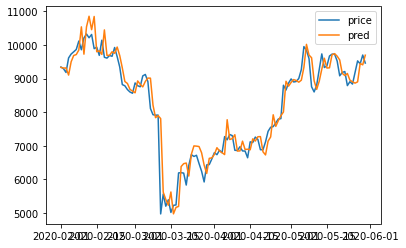

In [202]:
from sklearn import ensemble

rf = ensemble.RandomForestRegressor()
rf.n_estimators = int(200)
rf.fit(X_train, y_train_reg)

pred_rf = forecast(rf, X_test, y_test_reg, X_test)

Feature ranking:
1. feature 0 (0.319153)
2. feature 8 (0.303412)
3. feature 7 (0.244598)
4. feature 5 (0.062779)
5. feature 6 (0.035928)
6. feature 4 (0.012883)
7. feature 10 (0.009996)
8. feature 1 (0.004188)
9. feature 2 (0.003512)
10. feature 3 (0.001941)
11. feature 12 (0.000425)
12. feature 13 (0.000404)
13. feature 11 (0.000393)
14. feature 9 (0.000388)


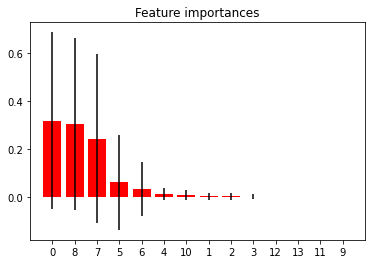

In [203]:
# only works for rf
def feature_importance_rf(model, X):
  importances = model.feature_importances_
  std = np.std([para.feature_importances_ for para in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

  # Plot the impurity-based feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()


# test feature importance from lag 0 to lag 15
feature_importance_rf(rf, X_train)

only feature lag 2 contributes a little, around 0.01, better to use without lag in rf.

Q: how to find feature importance for other models?

## CNN

In [0]:
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.models import Sequential
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

def build_cnn(dim):
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=1, padding='same', 
                     strides=1, activation='sigmoid',input_shape=(dim,1)))
    model.add(Conv1D(filters=128, kernel_size=1, 
                     strides=1, activation='sigmoid'))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='sigmoid' ))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', 
                  metrics=['accuracy'], optimizer='adam')
    return model


 MAE: 0.0137, MAPE: 21.09%

 MSE: 0.0005, RMSE: 0.0215

 R^2: 0.9175, Sign Accuracy: 50.83%

 Mean Error with penalty: 0.0580


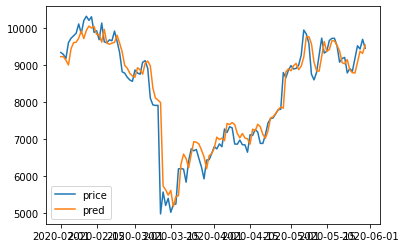

In [205]:
X_train_CNN = np.reshape(X_train.to_numpy(), (X_train.shape[0], X_train.shape[1], 1))
X_test_CNN = np.reshape(X_test.to_numpy(), (X_test.shape[0], X_test.shape[1], 1))

CNN = build_cnn(X_train_CNN.shape[1])
CNN.fit(X_train_CNN, y_train_reg, batch_size=150, nb_epoch=1000,
        validation_split=0.05, verbose=0)
pred_CNN = forecast(CNN, X_test_CNN, y_test_reg, X_test)

## LSTM


 MAE: 0.0121, MAPE: 21.44%

 MSE: 0.0004, RMSE: 0.0204

 R^2: 0.9263, Sign Accuracy: 58.33%

 Mean Error with penalty: 0.0460


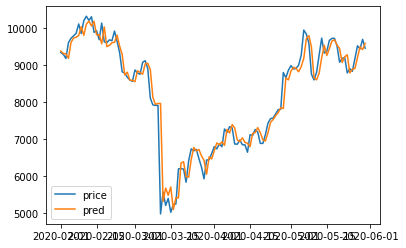

In [206]:
from keras.layers import LSTM

# reshape input to be 3D [samples, timesteps, features]
X_train_LSTM = np.reshape(X_train.to_numpy(), (X_train.shape[0], 1, X_train.shape[1]))
X_test_LSTM = np.reshape(X_test.to_numpy(), (X_test.shape[0], 1, X_test.shape[1]))

# design network
lstm = Sequential()
lstm.add(LSTM(259, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
lstm.add(Dense(1))

lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# fit network
history = lstm.fit(X_train_LSTM, y_train_reg, epochs=1000, batch_size=260, 
                   validation_data=(X_test_LSTM, y_test_reg), 
                   verbose=0, shuffle=False)

# plot history
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
#plt.legend()
#plt.show()

pred_LSTM = forecast(lstm, X_test_LSTM, y_test_reg, X_test)

## GRU


 MAE: 0.0118, MAPE: 21.75%

 MSE: 0.0004, RMSE: 0.0203

 R^2: 0.9268, Sign Accuracy: 54.17%

 Mean Error with penalty: 0.0471


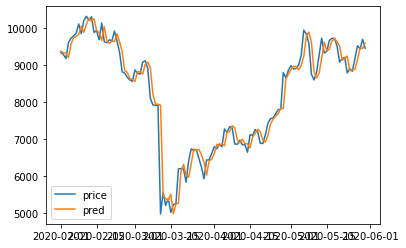

In [212]:
from keras.layers import GRU

gru = Sequential()
gru.add(GRU(230, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]), 
            go_backwards=True, activation='sigmoid', return_sequences=False))
gru.add(Dense(1))

gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
gru.fit(X_train_LSTM, y_train_reg, batch_size=360, epochs=1000, 
        validation_data=(X_test_LSTM, y_test_reg), shuffle=False, verbose=0)

pred_gru = forecast(gru, X_test_LSTM, y_test_reg, X_test)

# Combination

## Simple


 MAE: 0.0118, MAPE: 21.69%

 MSE: 0.0004, RMSE: 0.0203

 R^2: 0.9268, Sign Accuracy: 58.33%

 Mean Error with penalty: 0.0443


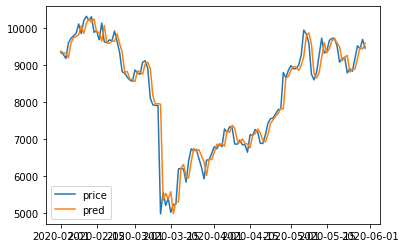

In [213]:
y_pred_simple = (pred_LSTM + pred_gru + pred_rr)/3
performance(y_test_reg, y_pred_simple, X_test)

## GRR


 MAE: 0.0117, MAPE: 21.57%

 MSE: 0.0004, RMSE: 0.0202

 R^2: 0.9276, Sign Accuracy: 60.00%

 Mean Error with penalty: 0.0444


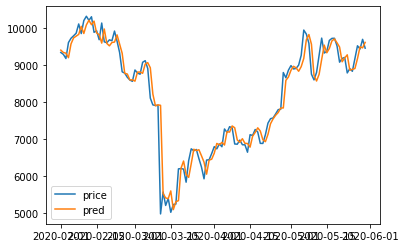

In [214]:
# GRR-1: with intercept 
from sklearn.linear_model import LinearRegression

pred_concat = pd.concat([pred_LSTM, pred_gru, pred_rr], axis = 1)
reg = LinearRegression().fit(pred_concat, y_test_reg)
y_pred_GRR1 = pd.DataFrame(reg.predict(pred_concat))

y_pred_GRR1 = y_pred_GRR1.set_index(y_test_reg.index)
y_pred_GRR1.columns = ['Pred']
performance(y_test_reg, y_pred_GRR1, X_test)


 MAE: 0.0118, MAPE: 21.52%

 MSE: 0.0004, RMSE: 0.0202

 R^2: 0.9275, Sign Accuracy: 60.00%

 Mean Error with penalty: 0.0421


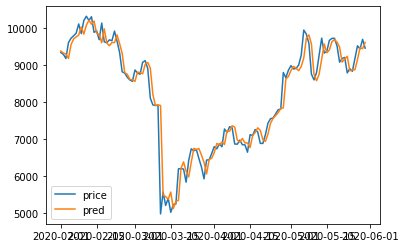

In [215]:
# GRR-2: without intercept 
from sklearn.linear_model import LinearRegression

pred_concat = pd.concat([pred_LSTM, pred_gru, pred_rr, pred_naive], axis = 1)
reg = LinearRegression(fit_intercept=False).fit(pred_concat, y_test_reg)
y_pred_GRR2 = pd.DataFrame(reg.predict(pred_concat))

y_pred_GRR2 = y_pred_GRR2.set_index(y_test_reg.index)
y_pred_GRR2.columns = ['Pred']

performance(y_test_reg, y_pred_GRR2, X_test)

## Lasso


 MAE: 0.0118, MAPE: 21.55%

 MSE: 0.0004, RMSE: 0.0202

 R^2: 0.9272, Sign Accuracy: 55.83%

 Mean Error with penalty: 0.0453


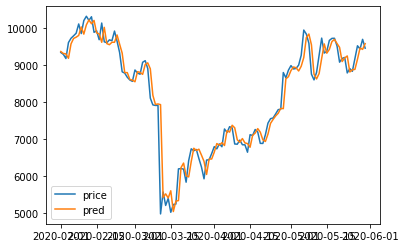

In [216]:
from sklearn.linear_model import LassoCV

pred_concat = pd.concat([pred_LSTM, pred_gru, pred_rr, pred_naive], axis = 1)
lasso = LassoCV().fit(pred_concat, y_test_reg)
y_pred_lasso = pd.DataFrame(lasso.predict(pred_concat))
y_pred_lasso = y_pred_lasso.set_index(y_test_reg.index)
y_pred_lasso.columns = ['Pred']

performance(y_test_reg, y_pred_lasso, X_test)

## Kalman


In [120]:
!pip install pykalman

     |████████████████████████████████| 235kB 4.6MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp36-none-any.whl size=48464 sha256=e12293cdc010878157b999284f64a6e6da68ffc339ef7bf7e94fff940788682f
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [0]:
from pykalman import KalmanFilter

pred_concat = pd.concat([pred_LSTM, pred_gru, pred_rr], axis = 1)
pred_obs = pred_concat.values[:, np.newaxis]


initial_reg = LinearRegression(fit_intercept=False)
initial_reg.fit(pred_obs[0, :, :],np.array([y_test_reg.iloc[0]]))
kf = KalmanFilter(initial_state_mean=initial_reg.coef_,
                  initial_state_covariance=np.zeros((3, 3)),
                  transition_matrices=np.eye(3),
                  observation_matrices=pred_obs,
                  )

state_means, state_covs = kf.filter(y_test_reg)

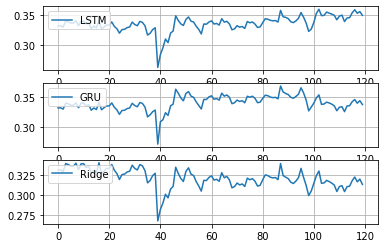


 MAE: 0.0075, MAPE: 22.07%

 MSE: 0.0001, RMSE: 0.0118

 R^2: 0.9754, Sign Accuracy: 80.00%

 Mean Error with penalty: 0.0257


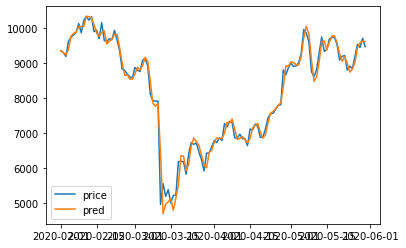

In [218]:
pred_kalman = 0
for i in range(3):
  pred_kalman += np.multiply(pred_concat.values[:,i], state_means[:,i]) 
pred_kalman = pd.DataFrame(pred_kalman).set_index(y_test_reg.index)

# Plots
plt.figure(1)
ax1 = plt.subplot(311)
plt.plot(state_means[:, 0], label="LSTM")
plt.grid()
plt.legend(loc="upper left")

ax2 = plt.subplot(312)
plt.plot(state_means[:, 1], label="GRU")
plt.grid()
plt.legend(loc="upper left")

ax3 = plt.subplot(313)
plt.plot(state_means[:, 2], label="Ridge")
plt.grid()
plt.legend(loc="upper left")
plt.show()

# check the result
performance(y_test_reg, pred_kalman, X_test)

# Trading Strategy 1: B&H

In [219]:
BH_data = pd.concat([y_test_reg, X_test['0']], axis=1)
BH_data.columns = ['Future_Price', 'Price']
BH_data['Return'] = BH_data['Future_Price']/BH_data['Price'] - 1.0
ret = BH_data['Return'].mean(axis=0)
ret_std = BH_data['Return'].std(axis=0)
BH_monthly_ret = 30*ret
BH_monthly_ret_vol = np.sqrt(30)*ret_std
BH_ratio = BH_monthly_ret/BH_monthly_ret_vol

# compute Maximum Drawdown of returns 
cum_ret = BH_data['Return'].cumsum()

low_ind = np.argmax(np.maximum.accumulate(cum_ret) - cum_ret) # end of the period
high_ind = np.argmax(cum_ret[:low_ind]) # start of period
max_dd = cum_ret[low_ind]-cum_ret[high_ind]

print('Monthly return (excluding costs):', '{:.2f}%'.format(BH_monthly_ret*100))
print('Monthly volatility: {:.2f}%'.format(BH_monthly_ret_vol*100))
print('Information ratio (excluding costs): {:.2f}'.format(BH_ratio))
print('Maximum drwadown:', '{:.2f}%'.format(max_dd*100))

Monthly return (excluding costs): 5.11%
Monthly volatility: 29.63%
Information ratio (excluding costs): 0.17
Maximum drwadown: -63.86%


# Strategy 2: Mean Reversion


In [0]:
# long if z score < -0.5, short if z score > 0.5, otherwise clear positions 
def mr_leverage(row):
  if np.abs(row['ZScores']) >= 2:
    return -5*np.sign(row['ZScores']) # leverage 5 if > 2 std
  elif 1 <= np.abs(row['ZScores']) < 2:
    return -2*np.sign(row['ZScores']) # leverage 2 if > 1 std
  elif 0.5 <= np.abs(row['ZScores']) < 1:
    return -np.sign(row['ZScores'])
  else:
    return 0


def mean_reversion_strategy(trading):
  # use one year historical data to compute zscores
  mr_data = pd.DataFrame(pd.concat([X_train['0'].iloc[-365:], trading['Price']], axis=0))
  mr_data.columns = ['Price']
  mr_data['Mean'] = mr_data['Price'].expanding(1).mean()
  mr_data['Std'] = mr_data['Price'].expanding(1).std()
  mr_data['ZScores'] = (mr_data['Price'] - mr_data['Mean'])/mr_data['Std']

  trading['ZScores'] = mr_data['ZScores'][TIME:].values
  trading['MR_Strategy_Sign'] = trading.apply(lambda x: mr_leverage(x), axis=1)
  
  return trading

In [280]:
summary(X_test['0'], y_test_reg, pred_LSTM, X_test['MA_Avg'], False, False, MR=True)

Mean Reversion: True
Excluding costs:
Monthly return (excluding costs): 23.05%
Monthly volatility: 29.20%
Information ratio (excluding costs): 0.79
Maximum drwadown: -20.34%
Including costs:
Monthly transactions: 4
Monthly transcation costs: 0.80%
Monthly return (including costs): 22.25%
Information ratio (including costs): 0.76


Have tried leverage with 10, 5, 1. Although the return doubled, but the information ratio keeps the same since the volatility(risk) also doubled.

Whatever the model we used, the Mean Reversion gives the same results since it does't envolve any predictions.

# Strategy 3: Naive

## excluding cost

In [0]:
def monthly_return(trading, leverage, MA, MR=False):

  # return = R_(t+1)/R_(t) - 1
  trading['Return'] = trading['Future_price']/trading['Price'] - 1.0

  # long if prediction of tomorrow is bigger than today's price, else short
  trading['Strategy'] = trading.apply(
      lambda x: (x['Return']) if x['Price'] < x['Prediction'] 
      else (-x['Return']), 
      axis=1)
  ret = trading['Strategy'].mean(axis=0)
  ret_std = trading['Strategy'].std(axis=0)

  if MA:
    trading['MA_Strategy'] = trading['Return'] * trading['MA_Strategy_Sign']
    ret = trading['MA_Strategy'].mean(axis=0)
    ret_std = trading['MA_Strategy'].std(axis=0)
  
  if MR:
    trading['MR_Strategy'] = trading['Return'] * trading['MR_Strategy_Sign']
    ret = trading['MR_Strategy'].mean(axis=0)
    ret_std = trading['MR_Strategy'].std(axis=0)

  if leverage:
    if MA:
      trading['Lev_Strategy'] = trading['MA_Strategy']*trading['Leverage']
    else:
      trading['Lev_Strategy'] = trading['Strategy']*trading['Leverage']
    ret = trading['Lev_Strategy'].mean(axis=0)
    ret_std = trading['Lev_Strategy'].std(axis=0)
  
  return 30*ret, np.sqrt(30)*ret_std

## Max Drawdown

In [0]:
def max_drawdown(trading, leverage, MA, MR=False):
  # compute Maximum Drawdown of returns 
  cum_ret = trading['Strategy'].values.cumsum()
  
  if MA:
    cum_ret = trading['MA_Strategy'].values.cumsum()

  if MR:
    cum_ret = trading['MR_Strategy'].values.cumsum()

  if leverage:
    cum_ret = trading['Lev_Strategy'].values.cumsum()

  low_ind = np.argmax(np.maximum.accumulate(cum_ret) - cum_ret) # end of the period
  high_ind = np.argmax(cum_ret[:low_ind]) # start of period
  max_drawdown = cum_ret[low_ind]-cum_ret[high_ind]
  #plt.plot(cum_ret)
  #plt.plot([low_ind, high_ind], [cum_ret[low_ind], cum_ret[high_ind]], 'o', color='Red', markersize=10)
  return max_drawdown

## including cost

In [0]:
# BITMEX: 0.075% * 2 + 0.05%(settlement) = 0.2%
RATE = 0.002 #Bitstamp: 0.25%

def transaction(trading, leverage, MA, MR=False):
  # assign 'long' as position +1, 'short' as position -1
  trading['Position'] = trading.apply(
      lambda x: (1) if x['Price'] < x['Prediction'] else (-1), axis=1)
  trading['Last_Pos'] = trading['Position'].shift(1)

  trading['Transaction'] = trading.apply(
      lambda x: (1) if x['Position'] != x['Last_Pos'] else (0), axis=1)
  trans = trading['Transaction'].sum()

  if MA:
    trading['MA_Last_Pos'] = trading['MA_Strategy_Sign'].shift(1)
    trading['MA_Trans'] = trading.apply(
        lambda x: (1) if x['MA_Strategy_Sign'] != x['MA_Last_Pos'] else (0), 
        axis=1)
    trans = trading['MA_Trans'].sum()

  if MR:
    trading['MR_Last_Pos'] = trading['MR_Strategy_Sign'].shift(1)
    trading['MR_Trans'] = trading.apply(
        lambda x: (1) if np.sign(x['MR_Strategy_Sign']) != np.sign(x['MR_Last_Pos']) 
        else (0), axis=1)
    trans = trading['MR_Trans'].sum()

  if leverage:
    if MA:
      trading['Lev_Trans'] = trading['MA_Trans'] * trading['Leverage']
    elif MR:
      trading['Lev_Trans'] = trading['MR_Trans'] * trading['Leverage']
    else:
      trading['Lev_Trans'] = trading['Transaction'] * trading['Leverage']
    # number of monthly transactions including leverage
    trans = trading['Lev_Trans'].sum()

  monthly_trans = int(30*trans/trading.shape[0])

  return monthly_trans, monthly_trans*RATE

# Strategy 4: MA cross-over

MA_avg is less than the price, a signal of up trend (sign +1). MA_avg is higher than the price, a signal of down trend (sign -1).

ONLY enter the market when both MA sign and prediction have the same sign. 


In [0]:
def MA_strategy(trading):
  # if price > MA, suppose an up trend, otherwise down trend
  trading['MA_Sign'] = trading.apply(
      lambda x: (1) if x['Price'] > x['MA_Price'] else (-1), axis=1)
  trading['Position'] = trading.apply(
      lambda x: (1) if x['Price'] < x['Prediction'] else (-1), axis=1)
  
  # if both MA sign and prediction sign are consistent, we change positions buy/sell 
  # otherwise, we clear positions
  trading['MA_Strategy_Sign'] = trading.apply(
      lambda x: (x['MA_Sign']) if x['MA_Sign']==x['Position'] else (0), axis=1)
  
  return trading

## dual MA cross-over

# Strategy 5: Leverage

In [0]:
#Bitmex allows 100x leverage
EXTREME_HIGH = 1.5
MIDIUM_HIGH = 0
UPPER_HIGH = 1
LOWER_HIGH = 0.5
MIDIUM_LOW = 2.5 
EXTREME_LOW = 1 

def assign_leverage(row, mean, std):
  if row['Diff'] > mean:
    if row['Diff'] > mean + 2*std:
      return EXTREME_HIGH
    elif row['Diff'] > mean + 1*std:
      return MIDIUM_HIGH
    else:
      return UPPER_HIGH
  elif row['Diff'] < mean - 2*std:
    return EXTREME_LOW
  elif row['Diff'] < mean - 1*std:
    return MIDIUM_LOW
  else:
    return LOWER_HIGH
  

def leverage_factor(vol):

  # return = R_(t+1)/R_(t) - 1
  vol['Return'] = vol['Future_price']/vol['Price'] - 1.0
  vol['Pred_Ret'] = vol['Prediction']/vol['Price'] - 1.0

  vol['Cum_Squared'] = ((vol['Return']-vol['Return'].mean())**2).cumsum()
  vol['Pred_Cum_Squared']=((vol['Pred_Ret']-vol['Pred_Ret'].mean())**2).cumsum()

  vol = vol.reset_index()
  # if statement aviods 0 devider
  vol['Volatility'] = vol.apply(
      lambda x: 
      (0) if int(x.name)==0 
      else (np.sqrt(x['Cum_Squared']/int(x.name)))*np.sqrt(30), 
      axis=1)
  vol['Pred_Volatility'] = vol.apply(
      lambda x: (0) if int(x.name)==0 
      else (np.sqrt(x['Pred_Cum_Squared']/int(x.name)))*np.sqrt(30),
      axis=1)
  
  vol = vol.set_index('Timestamp')
  vol['Diff'] = vol['Volatility'] - vol['Pred_Volatility']
  vol['Diff'].iloc[0] = vol['Diff'].iloc[1] #aviod 1st row w.o. vol difference

  # apply mean and std of difference of volatility to assign leverage
  diff_mean = vol['Diff'].mean()
  diff_std = vol['Diff'].std()
  vol['Leverage'] = vol.apply(lambda x: assign_leverage(x, diff_mean, diff_std),
                              axis=1)
  
  #vol[['Leverage', 'Pred_Volatility']].plot(subplots=True, color='blue',figsize=(8, 6))
  return vol

# Summary

In [0]:
def summary(price, future_price, pred, MA_price, leverage, MA, MR=False):
  trading = pd.concat([price, future_price, pred, MA_price], axis = 1)
  trading.columns = ['Price', 'Future_price', 'Prediction', 'MA_Price']

  if MA:
    trading = MA_strategy(trading)
  
  if MR:
    trading = mean_reversion_strategy(trading)

  if leverage:
    trading = leverage_factor(trading)

  if MR:
    print('Mean Reversion:', MR)
  else:
    print('MA:', MA, ' LEVERAGE:', leverage)

  # excluding costs
  monthly_ret_ex, monthly_ret_vol = monthly_return(trading, leverage, MA, MR)
  max_dd_ex = max_drawdown(trading, leverage, MA, MR)
  ratio_ex = monthly_ret_ex/monthly_ret_vol
  print('Excluding costs:')
  print('Monthly return (excluding costs): {:.2f}%'.format(monthly_ret_ex*100))
  print('Monthly volatility: {:.2f}%'.format(monthly_ret_vol*100))
  print('Information ratio (excluding costs): {:.2f}'.format(ratio_ex))
  print('Maximum drwadown:', '{:.2f}%'.format(max_dd_ex*100))


  # including costs
  num_trans, trans_cost = transaction(trading, leverage, MA, MR)
  monthly_ret_in = monthly_ret_ex - trans_cost
  ratio_in = monthly_ret_in/monthly_ret_vol
  print('Including costs:')
  print('Monthly transactions:', num_trans)
  print('Monthly transcation costs:', '{:.2f}%'.format(trans_cost*100))
  print('Monthly return (including costs):', '{:.2f}%'.format(monthly_ret_in*100))
  print('Information ratio (including costs): {:.2f}'.format(ratio_in))

In [0]:
def strategy_summary(price, future_price, pred, MA_price):
  trading = pd.concat([price, future_price, pred, MA_price], axis = 1)
  trading.columns = ['Price', 'Future_price', 'Prediction', 'MA_Price']

  # B & H return without cost
  strategy_ret = pd.DataFrame(BH_data['Return'].cumsum())
  strategy_ret.columns = ['B&H']

  # Mean reversion return without cost
  trading_MR = mean_reversion_strategy(trading)
  MR_ret_ex, MR_ret_vol = monthly_return(trading_MR, False, False, MR=True)
  strategy_ret['MR'] = trading_MR['MR_Strategy'].cumsum()

  # naive return w.o. cost
  naive_ret_ex, naive_ret_vol = monthly_return(trading, False, False)
  strategy_ret['Naive'] = trading['Strategy'].cumsum()

  # Moving average return w.o. cost
  trading_MA = MA_strategy(trading)
  MA_ret_ex, MA_ret_vol = monthly_return(trading_MA, False, True)
  strategy_ret['MA'] = trading_MA['MA_Strategy'].cumsum()
  
  # leverage return w.o. cost
  trading_lev = leverage_factor(trading)
  lev_ret_ex, lev_ret_vol = monthly_return(trading_lev, True, False)
  strategy_ret['Leverage'] = trading_lev['Lev_Strategy'].cumsum()

  # leverage + MA return w.o. cost 
  trading_lev_MA = leverage_factor(trading_MA)
  lev_MA_ret_ex, lev_MA_ret_vol = monthly_return(trading_lev_MA, True, True)
  strategy_ret['Lev&MA'] = trading_lev_MA['Lev_Strategy'].cumsum()

  # plot the returns of different strategies  
  strategy_ret.plot()
  plt.xlabel('Date')
  plt.ylabel('Return')
  plt.title('Figure .')
  plt.legend()
  plt.show()

MA: False  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 23.69%
Monthly volatility: 29.32%
Information ratio (excluding costs): 0.81
Maximum drwadown: -40.51%
Including costs:
Monthly transactions: 7
Monthly transcation costs: 1.40%
Monthly return (including costs): 22.29%
Information ratio (including costs): 0.76


MA: False  LEVERAGE: True
Excluding costs:
Monthly return (excluding costs): 28.24%
Monthly volatility: 25.79%
Information ratio (excluding costs): 1.10
Maximum drwadown: -18.63%
Including costs:
Monthly transactions: 9
Monthly transcation costs: 1.80%
Monthly return (including costs): 26.44%
Information ratio (including costs): 1.03


MA: True  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 9.29%
Monthly volatility: 12.73%
Information ratio (excluding costs): 0.73
Maximum drwadown: -14.38%
Including costs:
Monthly transactions: 7
Monthly transcation costs: 1.40%
Monthly return (including costs): 7.89%
Information ratio (including co

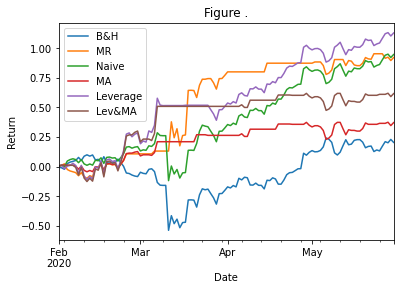

In [339]:
summary(X_test['0'], y_test_reg, pred_LSTM, X_test['MA_Avg'], False, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_LSTM, X_test['MA_Avg'], True, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_LSTM, X_test['MA_Avg'], False, True)
print('\n')
summary(X_test['0'], y_test_reg, pred_LSTM, X_test['MA_Avg'], True, True)
print('\n')
strategy_summary(X_test['0'], y_test_reg, pred_LSTM, X_test['MA_Avg'])

MA: False  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 4.71%
Monthly volatility: 29.63%
Information ratio (excluding costs): 0.16
Maximum drwadown: -54.12%
Including costs:
Monthly transactions: 13
Monthly transcation costs: 2.60%
Monthly return (including costs): 2.11%
Information ratio (including costs): 0.07


MA: False  LEVERAGE: True
Excluding costs:
Monthly return (excluding costs): 3.52%
Monthly volatility: 23.65%
Information ratio (excluding costs): 0.15
Maximum drwadown: -34.83%
Including costs:
Monthly transactions: 17
Monthly transcation costs: 3.40%
Monthly return (including costs): 0.12%
Information ratio (including costs): 0.01


MA: True  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): -0.20%
Monthly volatility: 11.03%
Information ratio (excluding costs): -0.02
Maximum drwadown: -24.69%
Including costs:
Monthly transactions: 13
Monthly transcation costs: 2.60%
Monthly return (including costs): -2.80%
Information ratio (including 

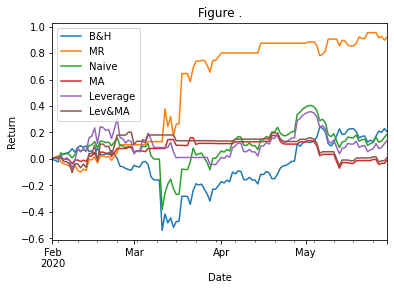

In [340]:
summary(X_test['0'], y_test_reg, pred_gru, X_test['MA_Avg'], False, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_gru, X_test['MA_Avg'], True, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_gru, X_test['MA_Avg'], False, True)
print('\n')
summary(X_test['0'], y_test_reg, pred_gru, X_test['MA_Avg'], True, True)
print('\n')
strategy_summary(X_test['0'], y_test_reg, pred_gru, X_test['MA_Avg'])

MA: False  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 1.39%
Monthly volatility: 29.64%
Information ratio (excluding costs): 0.05
Maximum drwadown: -69.27%
Including costs:
Monthly transactions: 15
Monthly transcation costs: 3.00%
Monthly return (including costs): -1.61%
Information ratio (including costs): -0.05


MA: False  LEVERAGE: True
Excluding costs:
Monthly return (excluding costs): 14.39%
Monthly volatility: 23.86%
Information ratio (excluding costs): 0.60
Maximum drwadown: -55.62%
Including costs:
Monthly transactions: 18
Monthly transcation costs: 3.60%
Monthly return (including costs): 10.79%
Information ratio (including costs): 0.45


MA: True  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): -1.86%
Monthly volatility: 15.90%
Information ratio (excluding costs): -0.12
Maximum drwadown: -36.75%
Including costs:
Monthly transactions: 15
Monthly transcation costs: 3.00%
Monthly return (including costs): -4.86%
Information ratio (includ

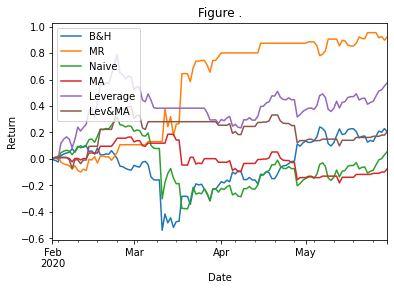

In [341]:
summary(X_test['0'], y_test_reg, pred_rr, X_test['MA_Avg'], False, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_rr, X_test['MA_Avg'], True, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_rr, X_test['MA_Avg'], False, True)
print('\n')
summary(X_test['0'], y_test_reg, pred_rr, X_test['MA_Avg'], True, True)
print('\n')
strategy_summary(X_test['0'], y_test_reg, pred_rr, X_test['MA_Avg'])

MA: False  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 74.43%
Monthly volatility: 26.32%
Information ratio (excluding costs): 2.83
Maximum drwadown: -12.37%
Including costs:
Monthly transactions: 8
Monthly transcation costs: 1.60%
Monthly return (including costs): 72.83%
Information ratio (including costs): 2.77


MA: False  LEVERAGE: True
Excluding costs:
Monthly return (excluding costs): 82.04%
Monthly volatility: 21.94%
Information ratio (excluding costs): 3.74
Maximum drwadown: -4.62%
Including costs:
Monthly transactions: 12
Monthly transcation costs: 2.40%
Monthly return (including costs): 79.64%
Information ratio (including costs): 3.63


MA: True  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 34.66%
Monthly volatility: 23.09%
Information ratio (excluding costs): 1.50
Maximum drwadown: -12.37%
Including costs:
Monthly transactions: 8
Monthly transcation costs: 1.60%
Monthly return (including costs): 33.06%
Information ratio (including 

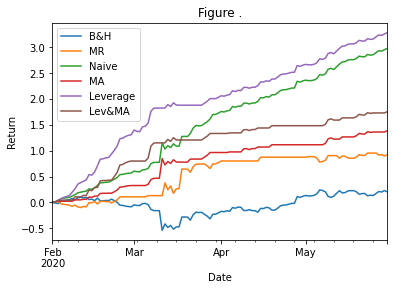

In [342]:
summary(X_test['0'], y_test_reg, pred_kalman, X_test['MA_Avg'], False, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_kalman, X_test['MA_Avg'], True, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_kalman, X_test['MA_Avg'], False, True)
print('\n')
summary(X_test['0'], y_test_reg, pred_kalman, X_test['MA_Avg'], True, True)
print('\n')
strategy_summary(X_test['0'], y_test_reg, pred_kalman, X_test['MA_Avg'])

MA: False  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 8.52%
Monthly volatility: 29.60%
Information ratio (excluding costs): 0.29
Maximum drwadown: -57.42%
Including costs:
Monthly transactions: 1
Monthly transcation costs: 0.20%
Monthly return (including costs): 8.32%
Information ratio (including costs): 0.28


MA: False  LEVERAGE: True
Excluding costs:
Monthly return (excluding costs): 12.23%
Monthly volatility: 20.83%
Information ratio (excluding costs): 0.59
Maximum drwadown: -26.65%
Including costs:
Monthly transactions: 3
Monthly transcation costs: 0.60%
Monthly return (including costs): 11.63%
Information ratio (including costs): 0.56


MA: True  LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 1.71%
Monthly volatility: 4.77%
Information ratio (excluding costs): 0.36
Maximum drwadown: -7.43%
Including costs:
Monthly transactions: 1
Monthly transcation costs: 0.20%
Monthly return (including costs): 1.51%
Information ratio (including costs)

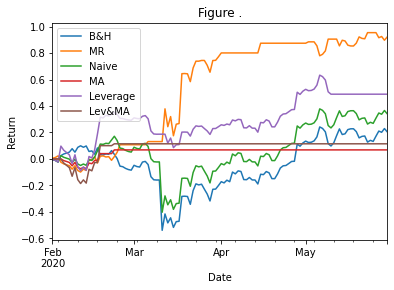

In [343]:
summary(X_test['0'], y_test_reg, pred_arma, X_test['MA_Avg'], False, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_arma, X_test['MA_Avg'], True, False)
print('\n')
summary(X_test['0'], y_test_reg, pred_arma, X_test['MA_Avg'], False, True)
print('\n')
summary(X_test['0'], y_test_reg, pred_arma, X_test['MA_Avg'], True, True)
print('\n')
strategy_summary(X_test['0'], y_test_reg, pred_arma, X_test['MA_Avg'])

ARMA: Transcation is 0 in naive because it looks like buy and hold strategy. Moreover, preidction return is always 0, so the prediction volatility is 0 as well.

LEVERAGE: False
Excluding costs:
Monthly return (excluding costs): 73.49%
Maximum drwadown: -11.93%
Including costs:
Monthly transactions: 8
Monthly transcation costs: 1.60%
Monthly return (including costs): 71.89%


LEVERAGE: True
Excluding costs:
Monthly return (excluding costs): 88.30%
Maximum drwadown: -4.46%
Including costs:
Monthly transactions: 12
Monthly transcation costs: 2.40%
Monthly return (including costs): 85.90%


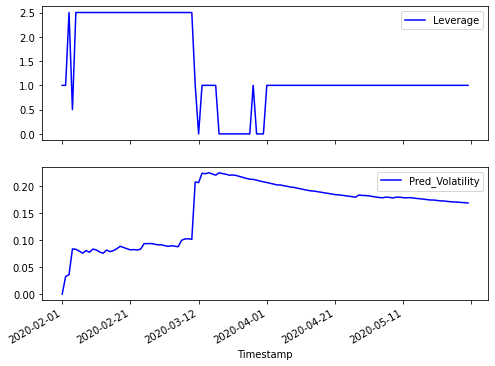

In [0]:
#summary with original data instead of MinMax normalization
test_data = undo_minmax_normalization(pred_kalman, X_test, data_minmax)
pred_kalman_price = test_data.iloc[:,0]
X_test_price = test_data.iloc[:,1]
summary(X_test_price, y_test_price, pred_kalman_price, False)
print('\n')
summary(X_test_price, y_test_price, pred_kalman_price, True)

Does the coefficients of leverage have connections with halving?

# Explore halving & Covid-19 effects

I have changed the train dataset from Apr 01, 2015 - Sep 30, 2019, and the test is from Oct 01 2019 - Jan 31, 2020. This is 4-months before our original test set. 

The results are shown in another file named 'Thesis_1day_31/01/2020'. I found that each model shows a much better perfomance by reducing it MSE aroung 4 times. However, the return also drops down due to the prices fluctuation in the test set last year is less serious than the test set before having.

The volatility and price fluctuation in several months before having are extremely large, which cause the forecast is less accurate, and the max drawdown becomes larger. But it brings high revene. If we could do leverage properly, we could control and limit the max drawdown to a bearable level without losing a lot of return.

# Limitations

## When trade more aggressively?
see Algorithmic Trading & DMA book page 237-242



## Transparent?

## Asymmetry behaviour of buyers and sellers?

## Imbalance of order book

No idea about the volume & depth of order book

## Seasonal? Day of week? Holiday? Time of day?

# END

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b461cf2e8>,
      dtype=object)

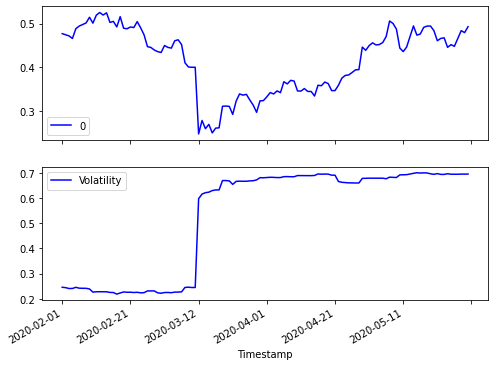

In [0]:
X_test[['0', 'Volatility']].plot(subplots=True, color='blue',figsize=(8, 6))

# Pi-Sigma Network

In [0]:
from keras.backend import log, exp, sum

SCALE = 1

def sigmoid(x):
    return 1./(1+exp(-x*SCALE))


 MAE: 0.0859, MAPE: 25.09%

 MSE: 0.0126, RMSE: 0.1123

 R^2: -1.2433, Sign Accuracy: 54.17%


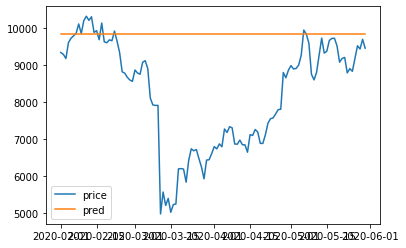

In [212]:
from keras import initializers
from keras.layers import Lambda

# determine the number of input features
n_features = X_train.shape[1]
# define model
model = Sequential()
model.add(Dense(128, input_shape=(n_features,), activation='relu'))
model.add(Lambda(lambda x: log(x+1e-8))) #BUG
initializer = initializers.Ones()
#model.add(Lambda(lambda x: sum(x, axis=0)))
# all weight is 1 in output layer
layer = Dense(1, 
                #activation='sigmoid', 
                kernel_initializer=initializer, 
                use_bias=False)
layer.trainable = False
model.add(layer)
model.add(Lambda(lambda x: exp(x)))
model.add(Lambda(sigmoid))
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# fit the model
model.fit(X_train, y_train_reg, epochs=500, batch_size=32, verbose=0)

pred_PSN = forecast(model, X_test, y_test_reg, X_test)

In [0]:
for i in layer.get_weights():
  print(i)

In [0]:
layer.trainable

In [0]:
n_features

In [0]:
from torch import nn, log, exp

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(n_features, 5)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(5, 1, bias=False)
        
        # Define sigmoid activation and softmax output 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        #x = self.relu(x)
        x = log(self.relu(x)+1e-8)
        x = exp(self.output(x))
        x = self.sigmoid(x)
        
        return x

In [0]:
from torch import optim
model = Network()

torch_tensor = torch.tensor(targets_df['targets'].values)

# Define the loss
criterion = nn.NLLLoss()
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.003)
epochs = 5
for e in range(epochs):
    running_loss = 0
    
        # Training pass
    optimizer.zero_grad()
        
    output = model(X_train)
    loss = criterion(output, y_train_reg)
    loss.backward()
    optimizer.step()
        
    running_loss += loss.item()
    
    print(f"Training loss: {running_loss/len(trainloader)}")

AttributeError: ignored